In [ ]:
"""
Copyright (C) 2022 King Saud University, Saudi Arabia
SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the
License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.

Author:  Hamdi Altaheri
"""

import math
import numpy as np
import pandas as pd
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense
from tensorflow.keras.layers import multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Dropout, MultiHeadAttention, LayerNormalization

#########################
# Advanced Attention Blocks
#########################
def attention_block(in_layer, attention_model, ratio=8, residual=False, apply_to_input=True):
    in_sh = in_layer.shape  # shape of the input tensor
    in_len = len(in_sh)
    expanded_axis = 2  # default expansion axis for 3D -> 4D conversion

    if attention_model == 'mha':   # Multi-head self attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer)
    elif attention_model == 'mhla':  # Multi-head local self-attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer, vanilla=False)
    elif attention_model == 'se':   # Squeeze-and-excitation layer
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = se_block(in_layer, ratio, residual, apply_to_input)
    elif attention_model == 'cbam': # Convolutional Block Attention Module
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = cbam_block(in_layer, ratio=ratio, residual=residual)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))

    if in_len == 3 and len(out_layer.shape) == 4:
        out_layer = tf.squeeze(out_layer, expanded_axis)
    elif in_len == 4 and len(out_layer.shape) == 3:
        out_layer = Reshape((in_sh[1], in_sh[2], in_sh[3]))(out_layer)
    return out_layer

def mha_block(input_feature, key_dim=8, num_heads=2, dropout=0.5, vanilla=True):
    """Multi-head self Attention block."""
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    if vanilla:
        x = MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x)
    else:
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        x = MultiHeadAttention_LSA(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x, attention_mask=diag_attn_mask)
    x = Dropout(0.3)(x)
    mha_feature = Add()([input_feature, x])
    return mha_feature

class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    """Local Multi-head Self Attention block (LSA)."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores

def se_block(input_feature, ratio=8, residual=False, apply_to_input=True):
    """Squeeze-and-Excitation (SE) block."""
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    if ratio != 0:
        se_feature = Dense(channel // ratio, activation='relu',
                           kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    se_feature = Dense(channel, activation='sigmoid',
                       kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    if tf.keras.backend.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)
    if apply_to_input:
        se_feature = multiply([input_feature, se_feature])
    if residual:
        se_feature = Add()([se_feature, input_feature])
    return se_feature

def cbam_block(input_feature, ratio=8, residual=False):
    """Convolutional Block Attention Module (CBAM) block."""
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    if residual:
        cbam_feature = Add()([input_feature, cbam_feature])
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    shared_layer_one = Dense(channel // ratio, activation='relu',
                             kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal',
                             use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same',
                          activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    return multiply([input_feature, cbam_feature])


#########################
# Original Data Loading & Preprocessing
#########################
data_path = '/kaggle/input/dataset123321/SEED-VIG_processed (1).csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nUnique subjects (subindex):")
print(df['subindex'].unique())
print("\nClass distribution (substate):")
print(df['substate'].value_counts())

# Prepare raw EEG data: features and labels
X = df.drop(columns=['subindex', 'substate']).values
y = df['substate'].values
X = X.reshape(X.shape[0], 17, 384)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#########################
# Continuous Wavelet Transform Preprocessing
#########################
def apply_cwt(X, scales, wavelet):
    n_samples, n_channels, n_timepoints = X.shape
    transformed = []
    for i in range(n_samples):
        sample = X[i]
        channel_cwt = []
        for ch in range(n_channels):
            coeffs, _ = pywt.cwt(sample[ch], scales, wavelet)
            channel_cwt.append(coeffs)
        sample_cwt = np.stack(channel_cwt, axis=-1)
        transformed.append(sample_cwt)
    return np.array(transformed)

scales = np.arange(1, 31)  # 30 scales
wavelet = 'morl'
X_train_cwt = apply_cwt(X_train, scales, wavelet)
X_test_cwt  = apply_cwt(X_test, scales, wavelet)
print("Transformed training data shape:", X_train_cwt.shape)  # Expected: (n_samples, 30, 384, 17)
print("Transformed test data shape:", X_test_cwt.shape)

#########################
# Adaptive Feature Fusion Module (previous implementation)
#########################
def adaptive_feature_fusion_module_2d(inputs, filters):
    branch1 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.SpatialDropout2D(0.3)(branch1)

    branch2 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.SpatialDropout2D(0.3)(branch2)

    concat = layers.Concatenate()([branch1, branch2])
    fused = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(concat)
    fused = layers.BatchNormalization()(fused)
    out = layers.Add()([inputs, fused])
    return out

#########################
# Build the Model with Advanced Attention Blocks
#########################
def build_model_advanced(input_shape, attention_type='cbam'):
    """
    Build a CNN model that uses advanced attention modules.

    Parameters:
      - input_shape: shape of the input data (e.g., (30, 384, 17))
      - attention_type: one of 'cbam', 'se', 'mha', 'mhla'
    """
    inputs = Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)

    # Initial convolutional block
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Apply advanced attention block
    x = attention_block(x, attention_model=attention_type, ratio=8, residual=True, apply_to_input=True)

    # Adaptive Feature Fusion
    x_aff = adaptive_feature_fusion_module_2d(x, 64)
    x = layers.Add()([x, x_aff])

    # Additional convolutional block
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Optionally, add another advanced attention block here
    x = attention_block(x, attention_model=attention_type, ratio=8, residual=True, apply_to_input=True)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the model with advanced attention (using 'cbam' by default)
model_advanced = build_model_advanced((30, 384, 17), attention_type='cbam')
model_advanced.summary()

#########################
# Train the Model
#########################
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
history = model_advanced.fit(X_train_cwt, y_train, epochs=100, batch_size=32,
                             validation_data=(X_test_cwt, y_test),
                             callbacks=[reduce_lr])

#########################
# Evaluate the Model
#########################
y_pred = (model_advanced.predict(X_test_cwt) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTrain Accuracy:", history.history['accuracy'][-1])
print("\nValidation Accuracy:", history.history['val_accuracy'][-1])
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nTest Accuracy:", test_accuracy)

Dataset Shape: (4566, 6530)

First 5 rows:
   EEG_channel_1_t1  EEG_channel_1_t2  EEG_channel_1_t3  EEG_channel_1_t4  \
0         -3.457432        -15.610134        -28.209033        -16.500817   
1         12.856846          7.200323          4.795857         13.225275   
2         13.143232          3.307855          8.480391          7.013710   
3         30.523582         28.615215         41.685072         28.333728   
4         -8.910801        -10.594044        -30.384980        -10.884113   

   EEG_channel_1_t5  EEG_channel_1_t6  EEG_channel_1_t7  EEG_channel_1_t8  \
0        -16.546740        -24.126600        -24.409480         -5.469685   
1          3.833067         15.926209         11.693700          9.498457   
2          2.753549         -6.774113          7.940243          2.431553   
3         25.406661         16.704956         18.192949         29.348514   
4         -2.765033         -6.931607         -2.220146         -5.399940   

   EEG_channel_1_t9  EEG_channe

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 30, 384, 17)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gaussian_noise            │ (None, 30, 384, 17)    │              0 │ input_layer[0][0]      │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 30, 384, 64)    │          9,856 │ gaussian_noise[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 30, 384, 64)    │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 30, 384, 64)    │              0 │ batch_normalization[0… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 15, 192, 64)    │              0 │ spatial_dropout2d[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ max_pooling2d[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 64)             │              0 │ max_pooling2d[0][0]    │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 8)        │            520 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 64)       │            576 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 64)       │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_1[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 64)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 15, 192, 64)    │              0 │ max_pooling2d[0][0],   │
│                      

 Total params: 255,069 (996.36 KB)

 Trainable params: 254,301 (993.36 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 55s 276ms/step - accuracy: 0.6600 - loss: 1.1443 - val_accuracy: 0.8096 - val_loss: 0.8664 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8433 - loss: 0.7971 - val_accuracy: 0.7899 - val_loss: 0.8278 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8956 - loss: 0.6631 - val_accuracy: 0.7090 - val_loss: 1.0031 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8901 - loss: 0.6365 - val_accuracy: 0.7462 - val_loss: 0.9411 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8979 - loss: 0.5669 - val_accuracy: 0.6827 - val_loss: 1.1092 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8995 - loss: 0.5470 - val_accuracy: 0.8643 - val_loss: 0.6031 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/s

In [ ]:
"""
Copyright (C) 2022 King Saud University, Saudi Arabia
SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the
http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.

Author:  Hamdi Altaheri
"""

import math
import numpy as np
import pandas as pd
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense
from tensorflow.keras.layers import multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Dropout, MultiHeadAttention, LayerNormalization

#########################
# Advanced Attention Blocks
#########################
def attention_block(in_layer, attention_model, ratio=8, residual=False, apply_to_input=True):
    in_sh = in_layer.shape  # shape of the input tensor
    in_len = len(in_sh)
    expanded_axis = 2  # default expansion axis for 3D -> 4D conversion

    if attention_model == 'mha':   # Multi-head self attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer)
    elif attention_model == 'mhla':  # Multi-head local self-attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer, vanilla=False)
    elif attention_model == 'se':   # Squeeze-and-excitation layer
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = se_block(in_layer, ratio, residual, apply_to_input)
    elif attention_model == 'cbam': # Convolutional Block Attention Module
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = cbam_block(in_layer, ratio=ratio, residual=residual)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))

    if in_len == 3 and len(out_layer.shape) == 4:
        out_layer = tf.squeeze(out_layer, expanded_axis)
    elif in_len == 4 and len(out_layer.shape) == 3:
        out_layer = Reshape((in_sh[1], in_sh[2], in_sh[3]))(out_layer)
    return out_layer

def mha_block(input_feature, key_dim=8, num_heads=2, dropout=0.5, vanilla=True):
    """Multi-head self Attention block."""
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    if vanilla:
        x = MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x)
    else:
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        x = MultiHeadAttention_LSA(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x, attention_mask=diag_attn_mask)
    x = Dropout(0.3)(x)
    mha_feature = Add()([input_feature, x])
    return mha_feature

class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    """Local Multi-head Self Attention block (LSA)."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores

def se_block(input_feature, ratio=8, residual=False, apply_to_input=True):
    """Squeeze-and-Excitation (SE) block."""
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    if ratio != 0:
        se_feature = Dense(channel // ratio, activation='relu',
                           kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    se_feature = Dense(channel, activation='sigmoid',
                       kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    if tf.keras.backend.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)
    if apply_to_input:
        se_feature = multiply([input_feature, se_feature])
    if residual:
        se_feature = Add()([se_feature, input_feature])
    return se_feature

def cbam_block(input_feature, ratio=8, residual=False):
    """Convolutional Block Attention Module (CBAM) block."""
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    if residual:
        cbam_feature = Add()([input_feature, cbam_feature])
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    shared_layer_one = Dense(channel // ratio, activation='relu',
                             kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal',
                             use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same',
                          activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    return multiply([input_feature, cbam_feature])

#########################
# Adaptive Feature Fusion Module (previous implementation)
#########################
def adaptive_feature_fusion_module_2d(inputs, filters):
    branch1 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.SpatialDropout2D(0.3)(branch1)

    branch2 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.SpatialDropout2D(0.3)(branch2)

    concat = layers.Concatenate()([branch1, branch2])
    fused = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(concat)
    fused = layers.BatchNormalization()(fused)
    out = layers.Add()([inputs, fused])
    return out

#########################
# Attention Guided Multi-Scale CNN Block
#########################
def attention_guided_multiscale_block(inputs, filters, attention_type='cbam'):
    # Multi-scale convolution branches
    branch1 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch1 = layers.BatchNormalization()(branch1)

    branch2 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch2 = layers.BatchNormalization()(branch2)

    branch3 = layers.Conv2D(filters, kernel_size=(7, 7), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch3 = layers.BatchNormalization()(branch3)

    # Concatenate multi-scale features
    concat = layers.Concatenate()([branch1, branch2, branch3])

    # Fuse using 1x1 convolution
    fused = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(concat)
    fused = layers.BatchNormalization()(fused)

    # Apply attention block on fused features
    attn = attention_block(fused, attention_model=attention_type, ratio=8, residual=True, apply_to_input=True)

    # Residual connection
    out = layers.Add()([inputs, attn])
    return out

#########################
# Original Data Loading & Preprocessing
#########################
data_path = '/kaggle/input/dataset123321/SEED-VIG_processed (1).csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nUnique subjects (subindex):")
print(df['subindex'].unique())
print("\nClass distribution (substate):")
print(df['substate'].value_counts())

# Prepare raw EEG data: features and labels
X = df.drop(columns=['subindex', 'substate']).values
y = df['substate'].values
X = X.reshape(X.shape[0], 17, 384)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#########################
# Continuous Wavelet Transform Preprocessing
#########################
def apply_cwt(X, scales, wavelet):
    n_samples, n_channels, n_timepoints = X.shape
    transformed = []
    for i in range(n_samples):
        sample = X[i]
        channel_cwt = []
        for ch in range(n_channels):
            coeffs, _ = pywt.cwt(sample[ch], scales, wavelet)
            channel_cwt.append(coeffs)
        sample_cwt = np.stack(channel_cwt, axis=-1)
        transformed.append(sample_cwt)
    return np.array(transformed)

scales = np.arange(1, 31)  # 30 scales
wavelet = 'morl'
X_train_cwt = apply_cwt(X_train, scales, wavelet)
X_test_cwt  = apply_cwt(X_test, scales, wavelet)
print("Transformed training data shape:", X_train_cwt.shape)  # Expected: (n_samples, 30, 384, 17)
print("Transformed test data shape:", X_test_cwt.shape)

#########################
# Build the Model with Advanced Attention Blocks and Attention Guided Multi-Scale CNN
#########################
def build_model_advanced(input_shape, attention_type='cbam'):
    """
    Build a CNN model that uses advanced attention modules and attention guided multi-scale block.

    Parameters:
      - input_shape: shape of the input data (e.g., (30, 384, 17))
      - attention_type: one of 'cbam', 'se', 'mha', 'mhla'
    """
    inputs = Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)

    # Initial convolutional block
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Apply advanced attention block
    x = attention_block(x, attention_model=attention_type, ratio=8, residual=True, apply_to_input=True)

    # Attention Guided Multi-Scale Block (replacing adaptive feature fusion module)
    x = attention_guided_multiscale_block(x, 64, attention_type=attention_type)

    # Additional convolutional block
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Optionally, add another advanced attention block here
    x = attention_block(x, attention_model=attention_type, ratio=8, residual=True, apply_to_input=True)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the model with advanced attention and attention guided multi-scale CNN (using 'cbam' by default)
model_advanced = build_model_advanced((30, 384, 17), attention_type='cbam')
model_advanced.summary()

#########################
# Train the Model (Original)
#########################
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
history = model_advanced.fit(X_train_cwt, y_train, epochs=100, batch_size=32,
                             validation_data=(X_test_cwt, y_test),
                             callbacks=[reduce_lr])

#########################
# Evaluate the Model
#########################
y_pred = (model_advanced.predict(X_test_cwt) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTrain Accuracy:", history.history['accuracy'][-1])
print("\nValidation Accuracy:", history.history['val_accuracy'][-1])
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nTest Accuracy:", test_accuracy)


Dataset Shape: (4566, 6530)

First 5 rows:
   EEG_channel_1_t1  EEG_channel_1_t2  EEG_channel_1_t3  EEG_channel_1_t4  \
0         -3.457432        -15.610134        -28.209033        -16.500817   
1         12.856846          7.200323          4.795857         13.225275   
2         13.143232          3.307855          8.480391          7.013710   
3         30.523582         28.615215         41.685072         28.333728   
4         -8.910801        -10.594044        -30.384980        -10.884113   

   EEG_channel_1_t5  EEG_channel_1_t6  EEG_channel_1_t7  EEG_channel_1_t8  \
0        -16.546740        -24.126600        -24.409480         -5.469685   
1          3.833067         15.926209         11.693700          9.498457   
2          2.753549         -6.774113          7.940243          2.431553   
3         25.406661         16.704956         18.192949         29.348514   
4         -2.765033         -6.931607         -2.220146         -5.399940   

   EEG_channel_1_t9  EEG_channe

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 30, 384, 17)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gaussian_noise_1          │ (None, 30, 384, 17)    │              0 │ input_layer_1[0][0]    │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 30, 384, 64)    │          9,856 │ gaussian_noise_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 30, 384, 64)    │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_4       │ (None, 30, 384, 64)    │              0 │ batch_normalization_5… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 15, 192, 64)    │              0 │ spatial_dropout2d_4[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ max_pooling2d_2[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_2    │ (None, 64)             │              0 │ max_pooling2d_2[0][0]  │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1, 1, 8)        │            520 │ reshape_4[0][0],       │
│                           │                        │                │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1, 1, 64)       │            576 │ dense_6[0][0],         │
│                           │                        │                │ dense_6[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 1, 1, 64)       │              0 │ dense_7[0][0],         │
│                           │                        │                │ dense_7[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 1, 1, 64)       │              0 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_4 (Multiply)

 Total params: 461,383 (1.76 MB)

 Trainable params: 460,487 (1.76 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 283ms/step - accuracy: 0.7128 - loss: 1.1318 - val_accuracy: 0.8753 - val_loss: 0.8272 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.8785 - loss: 0.7929 - val_accuracy: 0.7921 - val_loss: 0.8686 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.8997 - loss: 0.6764 - val_accuracy: 0.7965 - val_loss: 0.8577 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.9095 - loss: 0.6092 - val_accuracy: 0.7473 - val_loss: 0.9609 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9106 - loss: 0.5760 - val_accuracy: 0.8556 - val_loss: 0.6453 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9278 - loss: 0.5082 - val_accuracy: 0.9048 - val_loss: 0.5264 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 

In [ ]:
import pandas as pd
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#############################
# 1. Data Loading & Overview
#############################
data_path = '/kaggle/input/dataset123321/SEED-VIG_processed (1).csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nUnique subjects (subindex):")
print(df['subindex'].unique())
print("\nClass distribution (substate):")
print(df['substate'].value_counts())

#############################
# 2. Prepare Raw EEG Data
#############################
# Features: all columns except 'subindex' and 'substate'
X = df.drop(columns=['subindex', 'substate']).values
y = df['substate'].values

# Original shape is (n_samples, 17*384). Reshape to (n_samples, 17, 384)
X = X.reshape(X.shape[0], 17, 384)

# Split raw data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##############################################
# 3. Continuous Wavelet Transform Preprocessing
##############################################
# This function computes the CWT for each channel of a sample.
# We use scales 1 to 30 and the 'morl' (Morlet) wavelet.
def apply_cwt(X, scales, wavelet):
    n_samples, n_channels, n_timepoints = X.shape
    transformed = []
    for i in range(n_samples):
        sample = X[i]  # shape: (17, 384)
        channel_cwt = []
        for ch in range(n_channels):
            # Compute CWT on the signal of length 384
            coeffs, _ = pywt.cwt(sample[ch], scales, wavelet)
            # coeffs has shape (len(scales), n_timepoints) e.g. (30, 384)
            channel_cwt.append(coeffs)
        # Stack the CWT of each channel along the last axis.
        # Resulting shape for the sample: (len(scales), n_timepoints, n_channels) => (30, 384, 17)
        sample_cwt = np.stack(channel_cwt, axis=-1)
        transformed.append(sample_cwt)
    return np.array(transformed)

# Define scales and wavelet type
scales = np.arange(1, 31)  # 30 scales
wavelet = 'morl'

# Transform training and test sets using CWT
X_train_cwt = apply_cwt(X_train, scales, wavelet)
X_test_cwt  = apply_cwt(X_test, scales, wavelet)

# Print new shape
print("Transformed training data shape:", X_train_cwt.shape)  # Expected: (n_samples, 30, 384, 17)
print("Transformed test data shape:", X_test_cwt.shape)

#################################################
# 4. Define 2D Modules for TFA and Adaptive Fusion
#################################################
def temporal_frequency_attention_2d(inputs, filters):
    # Generate an attention map using a 1x1 Conv2D with sigmoid activation.
    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(inputs)
    # Multiply the attention map with the input features and add the residual.
    attn_features = layers.Multiply()([inputs, att_map])
    out = layers.Add()([inputs, attn_features])
    return out

def adaptive_feature_fusion_module_2d(inputs, filters):
    # Branch 1: Convolution with a (3,3) kernel.
    branch1 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.SpatialDropout2D(0.3)(branch1)

    # Branch 2: Convolution with a (5,5) kernel.
    branch2 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.SpatialDropout2D(0.3)(branch2)

    # Concatenate the outputs of both branches.
    concat = layers.Concatenate()([branch1, branch2])
    # Fuse the features with a 1x1 Conv2D.
    fused = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(concat)
    fused = layers.BatchNormalization()(fused)
    # Add a residual connection.
    out = layers.Add()([inputs, fused])
    return out

#############################################
# 5. Build the Model Using the CWT Features
#############################################
# The new input shape is (30, 384, 17): (scales, timepoints, channels)
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # Add Gaussian noise for input augmentation.
    x = layers.GaussianNoise(0.05)(inputs)

    # Initial Conv2D block.
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Apply Temporal-Frequencial Attention (adapted to 2D).
    x = temporal_frequency_attention_2d(x, 64)

    # Apply Adaptive Feature Fusion module (2D).
    x_aff = adaptive_feature_fusion_module_2d(x, 64)
    x = layers.Add()([x, x_aff])

    # Additional convolutional block.
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Global Average Pooling and fully connected layers.
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the model with input shape (30, 384, 17)
model = build_model((30, 384, 17))
model.summary()

#############################################
# 6. Train the Model
#############################################
# Callback to reduce learning rate on plateau.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(X_train_cwt, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test_cwt, y_test),
                    callbacks=[reduce_lr])

#############################################
# 7. Evaluate the Model
#############################################
y_pred = (model.predict(X_test_cwt) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTrain Accuracy:", history.history['accuracy'][-1])
print("\nValidation Accuracy:", history.history['val_accuracy'][-1])
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nTest Accuracy:", test_accuracy)


Dataset Shape: (4566, 6530)
Columns: ['EEG_channel_1_t1', 'EEG_channel_1_t2', 'EEG_channel_1_t3', 'EEG_channel_1_t4', 'EEG_channel_1_t5', 'EEG_channel_1_t6', 'EEG_channel_1_t7', 'EEG_channel_1_t8', 'EEG_channel_1_t9', 'EEG_channel_1_t10', 'EEG_channel_1_t11', 'EEG_channel_1_t12', 'EEG_channel_1_t13', 'EEG_channel_1_t14', 'EEG_channel_1_t15', 'EEG_channel_1_t16', 'EEG_channel_1_t17', 'EEG_channel_1_t18', 'EEG_channel_1_t19', 'EEG_channel_1_t20', 'EEG_channel_1_t21', 'EEG_channel_1_t22', 'EEG_channel_1_t23', 'EEG_channel_1_t24', 'EEG_channel_1_t25', 'EEG_channel_1_t26', 'EEG_channel_1_t27', 'EEG_channel_1_t28', 'EEG_channel_1_t29', 'EEG_channel_1_t30', 'EEG_channel_1_t31', 'EEG_channel_1_t32', 'EEG_channel_1_t33', 'EEG_channel_1_t34', 'EEG_channel_1_t35', 'EEG_channel_1_t36', 'EEG_channel_1_t37', 'EEG_channel_1_t38', 'EEG_channel_1_t39', 'EEG_channel_1_t40', 'EEG_channel_1_t41', 'EEG_channel_1_t42', 'EEG_channel_1_t43', 'EEG_channel_1_t44', 'EEG_channel_1_t45', 'EEG_channel_1_t46', 'EEG_

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 30, 384, 17)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gaussian_noise_2          │ (None, 30, 384, 17)    │              0 │ input_layer_2[0][0]    │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 30, 384, 64)    │          9,856 │ gaussian_noise_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 30, 384, 64)    │            256 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_6       │ (None, 30, 384, 64)    │              0 │ batch_normalization_1… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 15, 192, 64)    │              0 │ spatial_dropout2d_6[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 15, 192, 64)    │          4,160 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_10 (Multiply)    │ (None, 15, 192, 64)    │              0 │ max_pooling2d_4[0][0], │
│                           │                        │                │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 15, 192, 64)    │              0 │ max_pooling2d_4[0][0], │
│                           │                        │                │ multiply_10[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 15, 192, 64)    │         36,928 │ add_13[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 15, 192, 64)    │        102,464 │ add_13[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 15, 192, 64)    │            256 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 15, 192, 64)    │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_7       │ (None, 15, 192, 64)    │              0 │ batch_normalization_1… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_8  

 Total params: 253,697 (991.00 KB)

 Trainable params: 252,929 (988.00 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.7091 - loss: 1.0428 - val_accuracy: 0.7899 - val_loss: 0.8615 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8526 - loss: 0.7654 - val_accuracy: 0.7691 - val_loss: 0.8566 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8804 - loss: 0.6667 - val_accuracy: 0.7801 - val_loss: 0.7922 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.8848 - loss: 0.6260 - val_accuracy: 0.8282 - val_loss: 0.7186 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.8912 - loss: 0.5844 - val_accuracy: 0.8217 - val_loss: 0.7095 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9222 - loss: 0.5035 - val_accuracy: 0.7943 - val_loss: 0.7661 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/s

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding if needed
y_test_cat = to_categorical(y_test)
y_pred_prob = model.predict(X_test_cwt)
y_pred = (y_pred_prob > 0.5).astype("int32")

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 2. Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# 5. Feature Importance (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_cwt.reshape(len(X_test_cwt), -1))
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Feature Distribution')
plt.show()

# 6. t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_test_cwt.reshape(len(X_test_cwt), -1))
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test, palette='coolwarm')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Feature Visualization')
plt.show()

# 7. Class-wise Accuracy Bar Chart
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8, 5))
sns.barplot(x=np.unique(y_test), y=class_accuracies, palette='magma')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.show()

# 8. Error Distribution Plot
errors = np.abs(y_test - y_pred.reshape(-1))
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=5, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution')
plt.show()

# 9. Heatmap of Feature Correlation
corr_matrix = np.corrcoef(X_test_cwt.reshape(len(X_test_cwt), -1), rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.title('Feature Correlation Heatmap')
plt.show()

# 10. Grad-CAM (for CNN models)
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_output)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_output[0], weights)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

layer_name = 'conv2d'  # Change to your CNN layer
img = X_test_cwt[0:1]
gcam = grad_cam(model, img, layer_name)
plt.figure(figsize=(6, 5))
plt.imshow(gcam, cmap='jet', alpha=0.5)
plt.title('Grad-CAM Visualization')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#############################
# 1. Data Loading & Overview
#############################
data_path = '/kaggle/input/dataset123321/SEED-VIG_processed (1).csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nUnique subjects (subindex):")
print(df['subindex'].unique())
print("\nClass distribution (substate):")
print(df['substate'].value_counts())

#############################
# 2. Prepare Raw EEG Data
#############################
# Features: all columns except 'subindex' and 'substate'
X = df.drop(columns=['subindex', 'substate']).values
y = df['substate'].values

# Original shape is (n_samples, 17*384). Reshape to (n_samples, 17, 384)
X = X.reshape(X.shape[0], 17, 384)

# Split raw data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##############################################
# 3. Continuous Wavelet Transform Preprocessing
##############################################
# This function computes the CWT for each channel of a sample.
# We use scales 1 to 30 and the 'morl' (Morlet) wavelet.
def apply_cwt(X, scales, wavelet):
    n_samples, n_channels, n_timepoints = X.shape
    transformed = []
    for i in range(n_samples):
        sample = X[i]  # shape: (17, 384)
        channel_cwt = []
        for ch in range(n_channels):
            # Compute CWT on the signal of length 384
            coeffs, _ = pywt.cwt(sample[ch], scales, wavelet)
            # coeffs has shape (len(scales), n_timepoints) e.g. (30, 384)
            channel_cwt.append(coeffs)
        # Stack the CWT of each channel along the last axis.
        # Resulting shape for the sample: (len(scales), n_timepoints, n_channels) => (30, 384, 17)
        sample_cwt = np.stack(channel_cwt, axis=-1)
        transformed.append(sample_cwt)
    return np.array(transformed)

# Define scales and wavelet type
scales = np.arange(1, 31)  # 30 scales
wavelet = 'morl'

# Transform training and test sets using CWT
X_train_cwt = apply_cwt(X_train, scales, wavelet)
X_test_cwt  = apply_cwt(X_test, scales, wavelet)

# Print new shape
print("Transformed training data shape:", X_train_cwt.shape)  # Expected: (n_samples, 30, 384, 17)
print("Transformed test data shape:", X_test_cwt.shape)

#################################################
# 4. Define 2D Modules for TFA, Adaptive Fusion, and Attention Guided Multiscale CNN
#################################################
def temporal_frequency_attention_2d(inputs, filters):
    # Generate an attention map using a 1x1 Conv2D with sigmoid activation.
    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(inputs)
    # Multiply the attention map with the input features and add the residual.
    attn_features = layers.Multiply()([inputs, att_map])
    out = layers.Add()([inputs, attn_features])
    return out

def adaptive_feature_fusion_module_2d(inputs, filters):
    # Branch 1: Convolution with a (3,3) kernel.
    branch1 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.SpatialDropout2D(0.3)(branch1)

    # Branch 2: Convolution with a (5,5) kernel.
    branch2 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.SpatialDropout2D(0.3)(branch2)

    # Concatenate the outputs of both branches.
    concat = layers.Concatenate()([branch1, branch2])
    # Fuse the features with a 1x1 Conv2D.
    fused = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(concat)
    fused = layers.BatchNormalization()(fused)
    # Add a residual connection.
    out = layers.Add()([inputs, fused])
    return out

def attention_guided_multiscale_cnn_module(inputs, filters):
    # Branch with 3x3 convolution.
    branch3x3 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    # Branch with 5x5 convolution.
    branch5x5 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    # Branch with 7x7 convolution.
    branch7x7 = layers.Conv2D(filters, kernel_size=(7, 7), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    # Concatenate multiscale features.
    concatenated = layers.Concatenate()([branch3x3, branch5x5, branch7x7])
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.SpatialDropout2D(0.3)(concatenated)

    # Reduce the channels to match the desired filter count.
    reduced = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(concatenated)
    reduced = layers.BatchNormalization()(reduced)

    # Generate an attention map.
    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(reduced)
    att_features = layers.Multiply()([reduced, att_map])

    # Residual connection.
    residual = layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(inputs)
    out = layers.Add()([residual, att_features])
    out = layers.Activation('relu')(out)
    return out

#############################################
# 5. Build the Model Using the CWT Features
#############################################
# The new input shape is (30, 384, 17): (scales, timepoints, channels)
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # Add Gaussian noise for input augmentation.
    x = layers.GaussianNoise(0.05)(inputs)

    # Initial Conv2D block.
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Apply Temporal-Frequencial Attention (adapted to 2D).
    x = temporal_frequency_attention_2d(x, 64)

    # Apply Adaptive Feature Fusion module (2D).
    x_aff = adaptive_feature_fusion_module_2d(x, 64)
    x = layers.Add()([x, x_aff])

    # Apply Attention Guided Multiscale CNN module.
    x_agm = attention_guided_multiscale_cnn_module(x, 64)
    x = layers.Add()([x, x_agm])

    # Additional convolutional block.
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Global Average Pooling and fully connected layers.
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the model with input shape (30, 384, 17)
model = build_model((30, 384, 17))
model.summary()

#############################################
# 6. Train the Model
#############################################
# Callback to reduce learning rate on plateau.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(X_train_cwt, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test_cwt, y_test),
                    callbacks=[reduce_lr])

#############################################
# 7. Evaluate the Model
#############################################
y_pred = (model.predict(X_test_cwt) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTrain Accuracy:", history.history['accuracy'][-1])
print("\nValidation Accuracy:", history.history['val_accuracy'][-1])
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nTest Accuracy:", test_accuracy)


Dataset Shape: (4566, 6530)
Columns: ['EEG_channel_1_t1', 'EEG_channel_1_t2', 'EEG_channel_1_t3', 'EEG_channel_1_t4', 'EEG_channel_1_t5', 'EEG_channel_1_t6', 'EEG_channel_1_t7', 'EEG_channel_1_t8', 'EEG_channel_1_t9', 'EEG_channel_1_t10', 'EEG_channel_1_t11', 'EEG_channel_1_t12', 'EEG_channel_1_t13', 'EEG_channel_1_t14', 'EEG_channel_1_t15', 'EEG_channel_1_t16', 'EEG_channel_1_t17', 'EEG_channel_1_t18', 'EEG_channel_1_t19', 'EEG_channel_1_t20', 'EEG_channel_1_t21', 'EEG_channel_1_t22', 'EEG_channel_1_t23', 'EEG_channel_1_t24', 'EEG_channel_1_t25', 'EEG_channel_1_t26', 'EEG_channel_1_t27', 'EEG_channel_1_t28', 'EEG_channel_1_t29', 'EEG_channel_1_t30', 'EEG_channel_1_t31', 'EEG_channel_1_t32', 'EEG_channel_1_t33', 'EEG_channel_1_t34', 'EEG_channel_1_t35', 'EEG_channel_1_t36', 'EEG_channel_1_t37', 'EEG_channel_1_t38', 'EEG_channel_1_t39', 'EEG_channel_1_t40', 'EEG_channel_1_t41', 'EEG_channel_1_t42', 'EEG_channel_1_t43', 'EEG_channel_1_t44', 'EEG_channel_1_t45', 'EEG_channel_1_t46', 'EEG_

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 30, 384, 17)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gaussian_noise_3          │ (None, 30, 384, 17)    │              0 │ input_layer_3[0][0]    │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 30, 384, 64)    │          9,856 │ gaussian_noise_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 30, 384, 64)    │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_10      │ (None, 30, 384, 64)    │              0 │ batch_normalization_1… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 15, 192, 64)    │              0 │ spatial_dropout2d_10[… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 15, 192, 64)    │          4,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_11 (Multiply)    │ (None, 15, 192, 64)    │              0 │ max_pooling2d_6[0][0], │
│                           │                        │                │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 15, 192, 64)    │              0 │ max_pooling2d_6[0][0], │
│                           │                        │                │ multiply_11[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 15, 192, 64)    │         36,928 │ add_16[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 15, 192, 64)    │        102,464 │ add_16[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 15, 192, 64)    │            256 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 15, 192, 64)    │            256 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_11      │ (None, 15, 192, 64)    │              0 │ batch_normalization_1… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_12 

 Total params: 615,553 (2.35 MB)

 Trainable params: 614,273 (2.34 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 45s 252ms/step - accuracy: 0.7000 - loss: 1.2895 - val_accuracy: 0.8512 - val_loss: 0.9307 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.8499 - loss: 0.8845 - val_accuracy: 0.7779 - val_loss: 0.9703 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.8792 - loss: 0.7310 - val_accuracy: 0.7735 - val_loss: 0.9512 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.9119 - loss: 0.6335 - val_accuracy: 0.7199 - val_loss: 1.0504 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.9188 - loss: 0.5561 - val_accuracy: 0.8129 - val_loss: 0.7709 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.9196 - loss: 0.5298 - val_accuracy: 0.8414 - val_loss: 0.6635 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
"""
Copyright (C) 2022 King Saud University, Saudi Arabia
SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the
License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.

Author:  Hamdi Altaheri
"""

import math
import pandas as pd
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (LayerNormalization, Dropout, Add, Dense,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape,
                                     Permute, Activation, Lambda, Conv2D, Concatenate, multiply)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

###############################################
# Additional Attention Blocks
###############################################

def attention_block(in_layer, attention_model, ratio=8, residual=False, apply_to_input=True):
    in_sh = in_layer.shape  # shape of the input tensor
    in_len = len(in_sh)
    expanded_axis = 2  # default expansion axis for 3D -> 4D conversion

    if attention_model == 'mha':   # Multi-head self attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer)
    elif attention_model == 'mhla':  # Multi-head local self-attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer, vanilla=False)
    elif attention_model == 'se':   # Squeeze-and-excitation layer
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = se_block(in_layer, ratio, residual, apply_to_input)
    elif attention_model == 'cbam': # Convolutional Block Attention Module
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = cbam_block(in_layer, ratio=ratio, residual=residual)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))

    if in_len == 3 and len(out_layer.shape) == 4:
        out_layer = tf.squeeze(out_layer, expanded_axis)
    elif in_len == 4 and len(out_layer.shape) == 3:
        out_layer = Reshape((in_sh[1], in_sh[2], in_sh[3]))(out_layer)
    return out_layer

def mha_block(input_feature, key_dim=8, num_heads=2, dropout=0.5, vanilla=True):
    """Multi-head self Attention block."""
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    if vanilla:
        x = layers.MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x)
    else:
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        x = MultiHeadAttention_LSA(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x, attention_mask=diag_attn_mask)
    x = Dropout(0.3)(x)
    mha_feature = Add()([input_feature, x])
    return mha_feature

class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    """Local Multi-head Self Attention block (LSA)."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores

def se_block(input_feature, ratio=8, residual=False, apply_to_input=True):
    """Squeeze-and-Excitation (SE) block."""
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    if ratio != 0:
        se_feature = Dense(channel // ratio, activation='relu',
                           kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    se_feature = Dense(channel, activation='sigmoid',
                       kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    if tf.keras.backend.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)
    if apply_to_input:
        se_feature = multiply([input_feature, se_feature])
    if residual:
        se_feature = Add()([se_feature, input_feature])
    return se_feature

def cbam_block(input_feature, ratio=8, residual=False):
    """Convolutional Block Attention Module (CBAM) block."""
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    if residual:
        cbam_feature = Add()([input_feature, cbam_feature])
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    shared_layer_one = Dense(channel // ratio, activation='relu',
                             kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal',
                             use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    # Use GlobalMaxPooling2D instead of reducing on the channel axis.
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same',
                          activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    return multiply([input_feature, cbam_feature])

###############################################
# Preprocessing Functions
###############################################

def standardize_raw_data(X_train, X_test):
    # X_train and X_test shape: (n_samples, channels, timepoints)
    n_channels = X_train.shape[1]
    for ch in range(n_channels):
        scaler = StandardScaler()
        X_train[:, ch, :] = scaler.fit_transform(X_train[:, ch, :])
        X_test[:, ch, :] = scaler.transform(X_test[:, ch, :])
    return X_train, X_test

###############################################
# 1. Data Loading & Overview
###############################################
data_path = '/kaggle/input/dataset123321/SEED-VIG_processed (1).csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nUnique subjects (subindex):")
print(df['subindex'].unique())
print("\nClass distribution (substate):")
print(df['substate'].value_counts())

###############################################
# 2. Prepare Raw EEG Data
###############################################
X = df.drop(columns=['subindex', 'substate']).values
y = df['substate'].values
X = X.reshape(X.shape[0], 17, 384)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)
X_train, X_test = standardize_raw_data(X_train, X_test)

###############################################
# 3. Continuous Wavelet Transform Preprocessing
###############################################
def apply_cwt(X, scales, wavelet):
    n_samples, n_channels, n_timepoints = X.shape
    transformed = []
    for i in range(n_samples):
        sample = X[i]
        channel_cwt = []
        for ch in range(n_channels):
            coeffs, _ = pywt.cwt(sample[ch], scales, wavelet)
            channel_cwt.append(coeffs)
        sample_cwt = np.stack(channel_cwt, axis=-1)
        transformed.append(sample_cwt)
    return np.array(transformed)

scales = np.arange(1, 31)
wavelet = 'morl'
X_train_cwt = apply_cwt(X_train, scales, wavelet)
X_test_cwt  = apply_cwt(X_test, scales, wavelet)

print("Transformed training data shape:", X_train_cwt.shape)
print("Transformed test data shape:", X_test_cwt.shape)

###############################################
# 4. Define 2D Modules for TFA, Adaptive Fusion, and Attention Guided Multiscale CNN
###############################################
def temporal_frequency_attention_2d(inputs, filters):
    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(inputs)
    attn_features = layers.Multiply()([inputs, att_map])
    out = layers.Add()([inputs, attn_features])
    return out

def adaptive_feature_fusion_module_2d(inputs, filters):
    branch1 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.SpatialDropout2D(0.3)(branch1)

    branch2 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.SpatialDropout2D(0.3)(branch2)

    concat = layers.Concatenate()([branch1, branch2])
    fused = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(concat)
    fused = layers.BatchNormalization()(fused)
    out = layers.Add()([inputs, fused])
    return out

def attention_guided_multiscale_cnn_module(inputs, filters):
    branch3x3 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch5x5 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch7x7 = layers.Conv2D(filters, kernel_size=(7, 7), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    concatenated = layers.Concatenate()([branch3x3, branch5x5, branch7x7])
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.SpatialDropout2D(0.3)(concatenated)

    reduced = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(concatenated)
    reduced = layers.BatchNormalization()(reduced)

    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(reduced)
    att_features = layers.Multiply()([reduced, att_map])

    residual = layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(inputs)
    out = layers.Add()([residual, att_features])
    out = layers.Activation('relu')(out)
    return out

###############################################
# 5. Build the Model Using the CWT Features
###############################################
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)

    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = temporal_frequency_attention_2d(x, 64)

    x_aff = adaptive_feature_fusion_module_2d(x, 64)
    x = layers.Add()([x, x_aff])

    x_agm = attention_guided_multiscale_cnn_module(x, 64)
    x = layers.Add()([x, x_agm])

    # Extra attention block using CBAM
    x = attention_block(x, attention_model='cbam', ratio=8, residual=True, apply_to_input=True)

    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model((30, 384, 17))
model.summary()

###############################################
# 6. Train the Model
###############################################
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(X_train_cwt, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test_cwt, y_test),
                    callbacks=[reduce_lr])

###############################################
# 7. Evaluate the Model
###############################################
y_pred = (model.predict(X_test_cwt) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTrain Accuracy:", history.history['accuracy'][-1])
print("\nValidation Accuracy:", history.history['val_accuracy'][-1])
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nTest Accuracy:", test_accuracy)

Dataset Shape: (4566, 6530)
Columns: ['EEG_channel_1_t1', 'EEG_channel_1_t2', 'EEG_channel_1_t3', 'EEG_channel_1_t4', 'EEG_channel_1_t5', 'EEG_channel_1_t6', 'EEG_channel_1_t7', 'EEG_channel_1_t8', 'EEG_channel_1_t9', 'EEG_channel_1_t10', 'EEG_channel_1_t11', 'EEG_channel_1_t12', 'EEG_channel_1_t13', 'EEG_channel_1_t14', 'EEG_channel_1_t15', 'EEG_channel_1_t16', 'EEG_channel_1_t17', 'EEG_channel_1_t18', 'EEG_channel_1_t19', 'EEG_channel_1_t20', 'EEG_channel_1_t21', 'EEG_channel_1_t22', 'EEG_channel_1_t23', 'EEG_channel_1_t24', 'EEG_channel_1_t25', 'EEG_channel_1_t26', 'EEG_channel_1_t27', 'EEG_channel_1_t28', 'EEG_channel_1_t29', 'EEG_channel_1_t30', 'EEG_channel_1_t31', 'EEG_channel_1_t32', 'EEG_channel_1_t33', 'EEG_channel_1_t34', 'EEG_channel_1_t35', 'EEG_channel_1_t36', 'EEG_channel_1_t37', 'EEG_channel_1_t38', 'EEG_channel_1_t39', 'EEG_channel_1_t40', 'EEG_channel_1_t41', 'EEG_channel_1_t42', 'EEG_channel_1_t43', 'EEG_channel_1_t44', 'EEG_channel_1_t45', 'EEG_channel_1_t46', 'EEG_

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 30, 384, 17)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gaussian_noise_2          │ (None, 30, 384, 17)    │              0 │ input_layer_2[0][0]    │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 30, 384, 64)    │          9,856 │ gaussian_noise_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 30, 384, 64)    │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_8       │ (None, 30, 384, 64)    │              0 │ batch_normalization_1… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 15, 192, 64)    │              0 │ spatial_dropout2d_8[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 15, 192, 64)    │          4,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_4 (Multiply)     │ (None, 15, 192, 64)    │              0 │ max_pooling2d_2[0][0], │
│                           │                        │                │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 15, 192, 64)    │              0 │ max_pooling2d_2[0][0], │
│                           │                        │                │ multiply_4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 15, 192, 64)    │         36,928 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 15, 192, 64)    │        102,464 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 15, 192, 64)    │            256 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 15, 192, 64)    │            256 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_9       │ (None, 15, 192, 64)    │              0 │ batch_normalization_1… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_10 

 Total params: 616,747 (2.35 MB)

 Trainable params: 615,467 (2.35 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 80s 413ms/step - accuracy: 0.7082 - loss: 1.2746 - val_accuracy: 0.8282 - val_loss: 0.9558 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.8539 - loss: 0.8798 - val_accuracy: 0.9004 - val_loss: 0.7023 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.8840 - loss: 0.7422 - val_accuracy: 0.9026 - val_loss: 0.6110 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.8990 - loss: 0.6422 - val_accuracy: 0.9245 - val_loss: 0.5308 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.9143 - loss: 0.5755 - val_accuracy: 0.9278 - val_loss: 0.5071 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.9215 - loss: 0.5239 - val_accuracy: 0.9365 - val_loss: 0.4511 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━

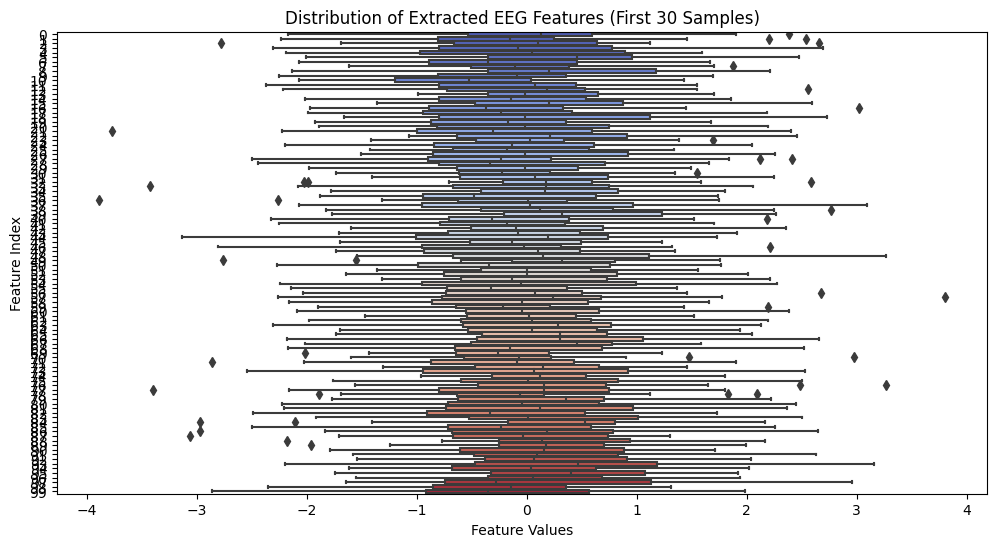

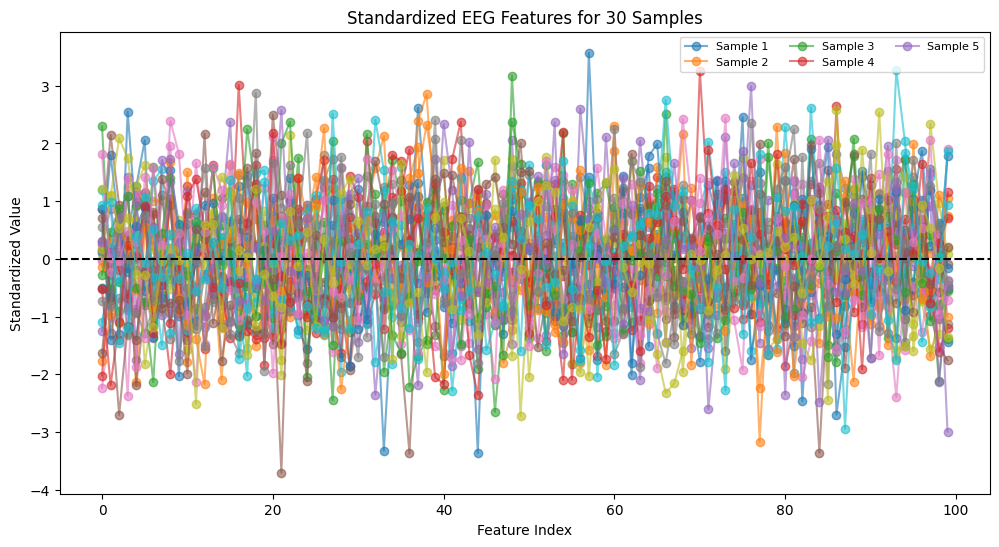

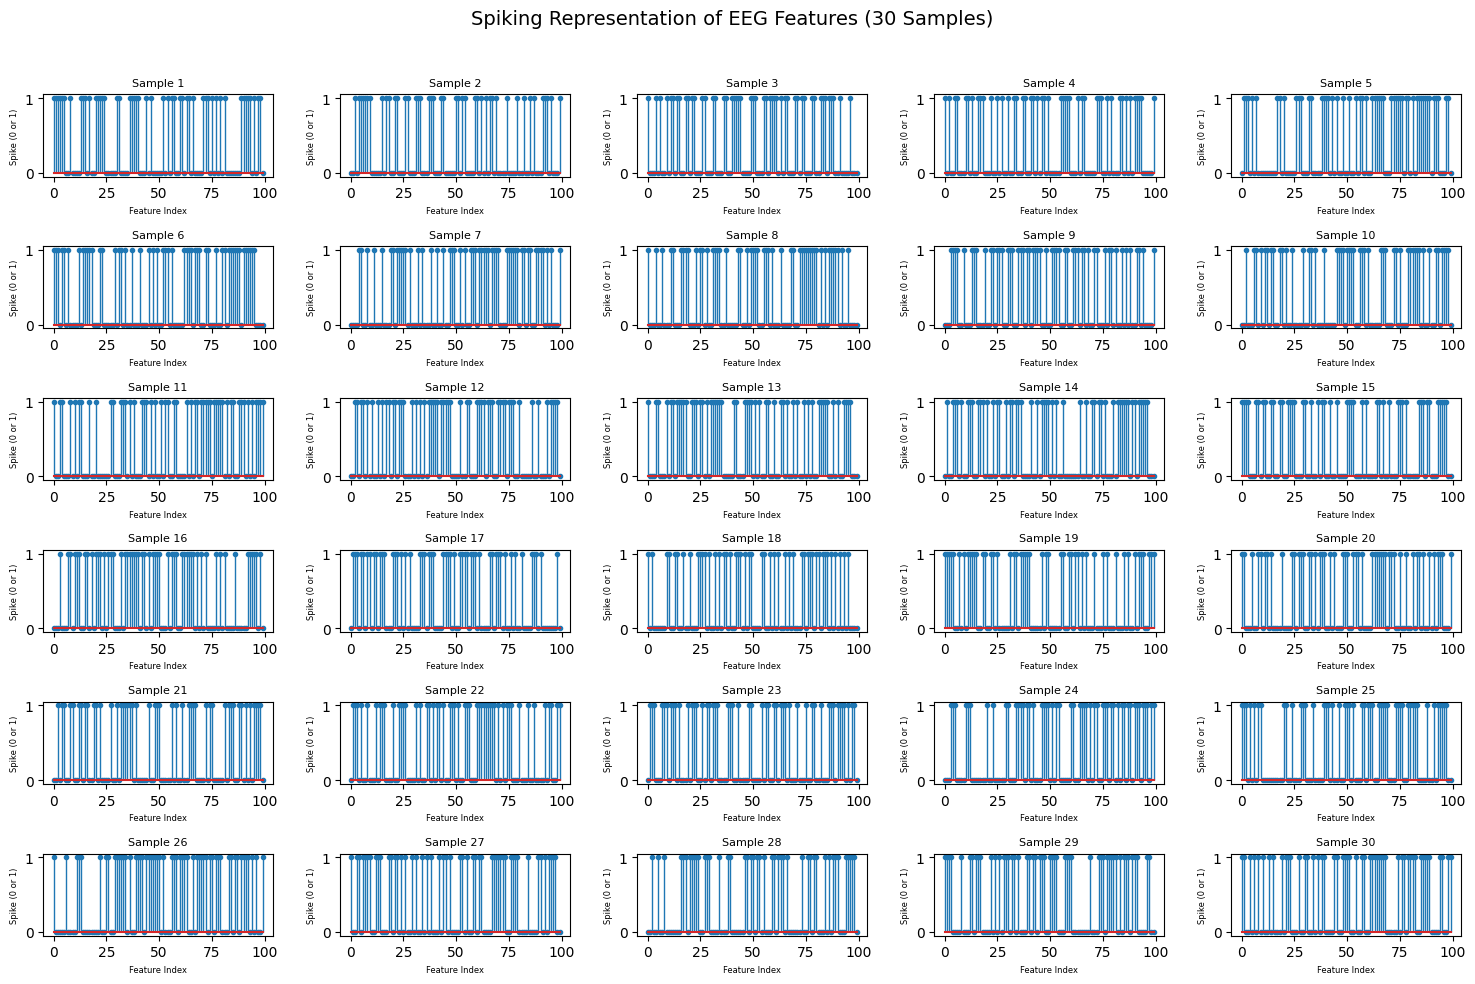

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For demonstration purposes, create dummy feature data if not already defined.
# Replace these with your actual feature extraction results.
if 'X_features' not in globals():
    # Dummy: 30 samples, 100 features each
    X_features = np.random.randn(30, 100)
if 'X_scaled' not in globals():
    # Standardize features for each sample (zero mean and unit variance)
    X_scaled = (X_features - np.mean(X_features, axis=1, keepdims=True)) / np.std(X_features, axis=1, keepdims=True)
if 'X_spikes' not in globals():
    # Create a binary spike representation: values > 0 become 1, else 0
    X_spikes = (X_scaled > 0).astype(int)

num_samples = 30

# Visualization 1: Boxplot of extracted EEG features for the first num_samples samples
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_features[:num_samples], orient="h", palette="coolwarm")
plt.title(f"Distribution of Extracted EEG Features (First {num_samples} Samples)")
plt.xlabel("Feature Values")
plt.ylabel("Feature Index")
plt.show()

# Visualization 2: Line plot of standardized EEG features for the first num_samples samples
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.plot(X_scaled[i], marker='o', alpha=0.6, label=f"Sample {i+1}" if i < 5 else "")
plt.axhline(0, color='black', linestyle='dashed')
plt.title(f"Standardized EEG Features for {num_samples} Samples")
plt.xlabel("Feature Index")
plt.ylabel("Standardized Value")
plt.legend(loc='upper right', fontsize=8, ncol=3)
plt.show()

# Visualization 3: Spiking representation of EEG features for the first num_samples samples
fig, axes = plt.subplots(6, 5, figsize=(15, 10))
fig.suptitle(f"Spiking Representation of EEG Features ({num_samples} Samples)", fontsize=14)

for i, ax in enumerate(axes.flatten()):
    if i < num_samples:
        markerline, stemline, baseline = ax.stem(X_spikes[i])
        plt.setp(markerline, markersize=3)
        plt.setp(stemline, linewidth=1)
        ax.set_title(f"Sample {i+1}", fontsize=8)
        ax.set_xlabel("Feature Index", fontsize=6)
        ax.set_ylabel("Spike (0 or 1)", fontsize=6)
    else:
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


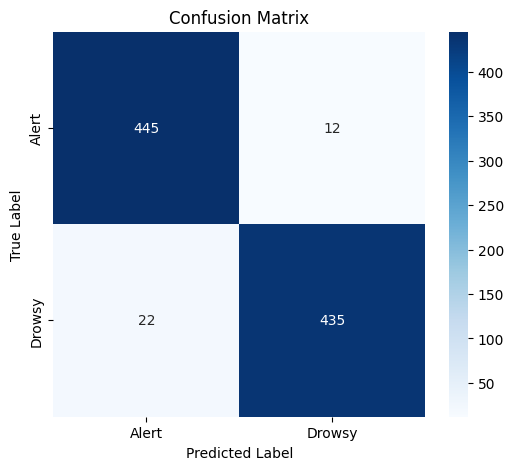

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Assuming you have already computed y_test and y_pred from your model evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ["Alert", "Drowsy"]

plot_confusion_matrix(conf_matrix, class_names)


In [ ]:


import math
import pandas as pd
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (LayerNormalization, Dropout, Add, Dense,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape,
                                     Permute, Activation, Lambda, Conv2D, Concatenate, multiply)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

###############################################
# Additional Attention Blocks
###############################################

def attention_block(in_layer, attention_model, ratio=8, residual=False, apply_to_input=True):
    in_sh = in_layer.shape  # shape of the input tensor
    in_len = len(in_sh)
    expanded_axis = 2  # default expansion axis for 3D -> 4D conversion

    if attention_model == 'mha':   # Multi-head self attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer)
    elif attention_model == 'mhla':  # Multi-head local self-attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer, vanilla=False)
    elif attention_model == 'se':   # Squeeze-and-excitation layer
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = se_block(in_layer, ratio, residual, apply_to_input)
    elif attention_model == 'cbam': # Convolutional Block Attention Module
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = cbam_block(in_layer, ratio=ratio, residual=residual)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))

    if in_len == 3 and len(out_layer.shape) == 4:
        out_layer = tf.squeeze(out_layer, expanded_axis)
    elif in_len == 4 and len(out_layer.shape) == 3:
        out_layer = Reshape((in_sh[1], in_sh[2], in_sh[3]))(out_layer)
    return out_layer

def mha_block(input_feature, key_dim=8, num_heads=2, dropout=0.5, vanilla=True):
    """Multi-head self Attention block."""
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    if vanilla:
        x = layers.MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x)
    else:
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        x = MultiHeadAttention_LSA(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x, attention_mask=diag_attn_mask)
    x = Dropout(0.3)(x)
    mha_feature = Add()([input_feature, x])
    return mha_feature

class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    """Local Multi-head Self Attention block (LSA)."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores

def se_block(input_feature, ratio=8, residual=False, apply_to_input=True):
    """Squeeze-and-Excitation (SE) block."""
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    if ratio != 0:
        se_feature = Dense(channel // ratio, activation='relu',
                           kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    se_feature = Dense(channel, activation='sigmoid',
                       kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    if tf.keras.backend.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)
    if apply_to_input:
        se_feature = multiply([input_feature, se_feature])
    if residual:
        se_feature = Add()([se_feature, input_feature])
    return se_feature

def cbam_block(input_feature, ratio=8, residual=False):
    """Convolutional Block Attention Module (CBAM) block."""
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    if residual:
        cbam_feature = Add()([input_feature, cbam_feature])
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    shared_layer_one = Dense(channel // ratio, activation='relu',
                             kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal',
                             use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same',
                          activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    return multiply([input_feature, cbam_feature])

###############################################
# Preprocessing Functions
###############################################

def standardize_raw_data(X_train, X_test):
    # X_train and X_test shape: (n_samples, channels, timepoints)
    n_channels = X_train.shape[1]
    for ch in range(n_channels):
        scaler = StandardScaler()
        X_train[:, ch, :] = scaler.fit_transform(X_train[:, ch, :])
        X_test[:, ch, :] = scaler.transform(X_test[:, ch, :])
    return X_train, X_test

###############################################
# 1. Data Loading & Overview
###############################################
data_path = '/kaggle/input/dataset123321/SEED-VIG_processed (1).csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nUnique subjects (subindex):")
print(df['subindex'].unique())
print("\nClass distribution (substate):")
print(df['substate'].value_counts())

###############################################
# 2. Prepare Raw EEG Data
###############################################
X = df.drop(columns=['subindex', 'substate']).values
y = df['substate'].values
X = X.reshape(X.shape[0], 17, 384)

# For k-fold cross validation, we use the full dataset (without an initial train-test split)
X, y = shuffle(X, y, random_state=42)

###############################################
# 3. Continuous Wavelet Transform Preprocessing Function
###############################################
def apply_cwt(X, scales, wavelet):
    n_samples, n_channels, n_timepoints = X.shape
    transformed = []
    for i in range(n_samples):
        sample = X[i]
        channel_cwt = []
        for ch in range(n_channels):
            coeffs, _ = pywt.cwt(sample[ch], scales, wavelet)
            channel_cwt.append(coeffs)
        sample_cwt = np.stack(channel_cwt, axis=-1)  # shape: (len(scales), n_timepoints, n_channels)
        transformed.append(sample_cwt)
    return np.array(transformed)

scales = np.arange(1, 31)
wavelet = 'morl'

###############################################
# 4. Define 2D Modules for TFA, Adaptive Fusion, and Attention Guided Multiscale CNN
###############################################
def temporal_frequency_attention_2d(inputs, filters):
    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(inputs)
    attn_features = layers.Multiply()([inputs, att_map])
    out = layers.Add()([inputs, attn_features])
    return out

def adaptive_feature_fusion_module_2d(inputs, filters):
    branch1 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.SpatialDropout2D(0.3)(branch1)

    branch2 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.SpatialDropout2D(0.3)(branch2)

    concat = layers.Concatenate()([branch1, branch2])
    fused = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(concat)
    fused = layers.BatchNormalization()(fused)
    out = layers.Add()([inputs, fused])
    return out

def attention_guided_multiscale_cnn_module(inputs, filters):
    branch3x3 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch5x5 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch7x7 = layers.Conv2D(filters, kernel_size=(7, 7), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    concatenated = layers.Concatenate()([branch3x3, branch5x5, branch7x7])
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.SpatialDropout2D(0.3)(concatenated)

    reduced = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(concatenated)
    reduced = layers.BatchNormalization()(reduced)

    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(reduced)
    att_features = layers.Multiply()([reduced, att_map])

    residual = layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(inputs)
    out = layers.Add()([residual, att_features])
    out = layers.Activation('relu')(out)
    return out

###############################################
# 5. Build the Model Using the CWT Features
###############################################
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)

    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = temporal_frequency_attention_2d(x, 64)

    x_aff = adaptive_feature_fusion_module_2d(x, 64)
    x = layers.Add()([x, x_aff])

    x_agm = attention_guided_multiscale_cnn_module(x, 64)
    x = layers.Add()([x, x_agm])

    # Extra attention block using CBAM
    x = attention_block(x, attention_model='cbam', ratio=8, residual=True, apply_to_input=True)

    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

###############################################
# 6. K-Fold Cross Validation
###############################################
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

acc_per_fold = []
loss_per_fold = []
fold_no = 1

for train_index, val_index in skf.split(X, y):
    print(f"\n--- Training for fold {fold_no} ---")

    # Split data for this fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Shuffle and standardize
    X_train_fold, y_train_fold = shuffle(X_train_fold, y_train_fold, random_state=42)
    X_val_fold, y_val_fold = shuffle(X_val_fold, y_val_fold, random_state=42)
    X_train_fold, X_val_fold = standardize_raw_data(X_train_fold, X_val_fold)

    # Apply CWT transformation
    X_train_fold_cwt = apply_cwt(X_train_fold, scales, wavelet)
    X_val_fold_cwt = apply_cwt(X_val_fold, scales, wavelet)

    # Build and train the model for this fold
    model_cv = build_model((30, 384, 17))
    reduce_lr_cv = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    history_cv = model_cv.fit(X_train_fold_cwt, y_train_fold, epochs=100, batch_size=32,
                              validation_data=(X_val_fold_cwt, y_val_fold),
                              callbacks=[reduce_lr_cv],
                              verbose=1)

    # Evaluate the model on the validation fold
    scores = model_cv.evaluate(X_val_fold_cwt, y_val_fold, verbose=0)
    print(f"Score for fold {fold_no}: Loss = {scores[0]:.4f} ; Accuracy = {scores[1]*100:.2f}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1

print("\n--- Average scores for all folds ---")
print(f"> Accuracy: {np.mean(acc_per_fold):.2f}% (+- {np.std(acc_per_fold):.2f}%)")
print(f"> Loss: {np.mean(loss_per_fold):.4f}")


Dataset Shape: (4566, 6530)
Columns: ['EEG_channel_1_t1', 'EEG_channel_1_t2', 'EEG_channel_1_t3', 'EEG_channel_1_t4', 'EEG_channel_1_t5', 'EEG_channel_1_t6', 'EEG_channel_1_t7', 'EEG_channel_1_t8', 'EEG_channel_1_t9', 'EEG_channel_1_t10', 'EEG_channel_1_t11', 'EEG_channel_1_t12', 'EEG_channel_1_t13', 'EEG_channel_1_t14', 'EEG_channel_1_t15', 'EEG_channel_1_t16', 'EEG_channel_1_t17', 'EEG_channel_1_t18', 'EEG_channel_1_t19', 'EEG_channel_1_t20', 'EEG_channel_1_t21', 'EEG_channel_1_t22', 'EEG_channel_1_t23', 'EEG_channel_1_t24', 'EEG_channel_1_t25', 'EEG_channel_1_t26', 'EEG_channel_1_t27', 'EEG_channel_1_t28', 'EEG_channel_1_t29', 'EEG_channel_1_t30', 'EEG_channel_1_t31', 'EEG_channel_1_t32', 'EEG_channel_1_t33', 'EEG_channel_1_t34', 'EEG_channel_1_t35', 'EEG_channel_1_t36', 'EEG_channel_1_t37', 'EEG_channel_1_t38', 'EEG_channel_1_t39', 'EEG_channel_1_t40', 'EEG_channel_1_t41', 'EEG_channel_1_t42', 'EEG_channel_1_t43', 'EEG_channel_1_t44', 'EEG_channel_1_t45', 'EEG_channel_1_t46', 'EEG_